In [1]:
import os, sys, random
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from  tensorflow import keras
from tqdm import tqdm
from REDInet import Utils

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585"],
                   ["outTable_572868058", "outTable_364841872"],
                   ["outTable_110067244", "outTable_597789462"]]

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
   
    filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cells)
    return samples, filespath


def make_imputations(cells, model_filepath):
    
    tables, tables_filespath =  give_inputs(cells)
    
    cols =  ["Region", "Position", "Strand"]
    
    if cells == "HEK293T":
        prefix = "HEK(hg38)"
        suffix_1 = "WT-KO"
        suffix_2 = "OVE-KO"
    elif cells == "a549":
        prefix = cells
        suffix_1 = "WT-SI"
    else:
        prefix = "HEK(hg19)"
        suffix_1 = "WT-KO"

    left = list(range(0, int((101-1)/2)))
    right = list(range(int((101-1)/2)+1, 101))
                    
    model = tf.keras.models.load_model(model_filepath)         
    imputations_filespath = os.path.join(tables_filespath, f"{cells}_imputations")
    if not os.path.isdir(imputations_filespath):
        os.mkdir(imputations_filespath)
        
    imputation_table_results = []
                    
    for imp in range(0, 51): 
        imputations_positions_tot = []
        
        y_true = []
        y_pred = []
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        for i in tqdm(range(3)):
            
            imputations_positions = []
            
            wt = pd.read_table(f"{tables_filespath}/{tables[i][0]}_intervals.tsv", sep="\t", usecols=cols)
            X = pd.read_table(f"{tables_filespath}/{tables[i][0]}_feature_vectors.tsv", header=None, sep="\t")
            X_3d = Utils().from_2_to_3_dimensions(X, 8)
            

            for y in range(X_3d.shape[0]): 
                temp = []
                positions = random.sample(left, k=imp) + random.sample(right, k=imp)
                for z in positions:  
                    temp.append(z)
                    X_3d[y, z, 4:8] = X_3d[y, z, 0:4]
                imputations_positions += temp
            
            X_3d_log2 = Utils().log_preprocessing(X_3d)
            y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)
            wt.loc[:, "Editing_Probability"] = y_hat_proba
            
            adars_inactive = pd.read_table(f"{tables_filespath}/{tables[i][1]}_intervals.tsv", sep="\t", usecols=cols)
            X = pd.read_table(f"{tables_filespath}/{tables[i][1]}_feature_vectors.tsv", header=None, sep="\t")
            X_3d = Utils().from_2_to_3_dimensions(X, 8)
            
            for y in range(X_3d.shape[0]):
                temp = []
                positions = random.sample(left, k=imp) + random.sample(right, k=imp)
                for z in positions:  
                    temp.append(z)
                    X_3d[y, z, 4:8] = X_3d[y, z, 0:4]
                imputations_positions += temp
                
            X_3d_log2 = Utils().log_preprocessing(X_3d)
            y_hat_proba = model.predict(X_3d_log2, batch_size=512, verbose=0)
            adars_inactive.loc[:, "Editing_Probability"] = y_hat_proba
    
            imputations_positions_tot.append(imputations_positions)
            
            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites_2.tsv"),
                                               sep="\t", usecols=["Region", "Position", "Class"])
              
            wt = wt.merge(sites, how="inner", on=["Region", "Position"])
    
            neg = sites[sites.loc[:, "Class"] == 0]
            adars_inactive = adars_inactive.merge(sites, how="inner", on=["Region", "Position"])

            final = pd.concat([wt, adars_inactive], axis=0)

            y_true += final.loc[:, "Class"].tolist()
            y_pred += final.loc[:, "Editing_Probability"].tolist()
            
            predictions = []
            for x in y_pred:
                if x > 0.5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            
            
            for j in range(len(y_true)):
                if y_true[j] == 1:
                    if predictions[j] == 1:
                        tp += 1
                    else:
                        fn += 1
                else:
                    if predictions[j] == 1:
                        fp += 1
                    else:
                        tn += 1

        imputation_table_results.append([imp*2, tp, fp, tn, fn])
        
        Utils().make_confusion_matrix(y_true,  y_pred,
                                      title = f"{prefix} {suffix_1} Inference Confusion Matrix With {imp*2} Imputations",
                                      figsize=(6,5),
                                      path=os.path.join(imputations_filespath, f"{cells}_{suffix_1}_{imp*2}_Imputations_Inference_Conf_Matrix.tiff"))        
                
        imputations_table = pd.DataFrame(imputations_positions_tot)
        imputations_table.to_csv(os.path.join(imputations_filespath, f"{cells}_{suffix_1}_{imp*2}_Imputations_Table_2.tsv"), 
                                 sep="\t", header=False, index=None)       
    
    imputation_table_results = pd.DataFrame(imputation_table_results, columns=["N_Imputations", "TP", "FP", "TN", "FN"])           

    imputation_table_results.to_csv(os.path.join(imputations_filespath, "HEK293T_WT-KO_Total_Imputations_Inference_Results_2.tsv"),
                                   sep="\t", index=None)
    
    return imputation_table_results, imputations_filespath

2024-08-02 15:33:56.407133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 15:33:56.407217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 15:33:56.407246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 15:33:56.417876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-08-02 15:33:58.251755: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-02 15:33:58.251808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: wn-gpu-8-3-2.recas.ba.infn.it
2024-08-02 15:33:58.251814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: wn-gpu-8-3-2.recas.ba.infn.it
2024-08-02 15:33:58.251933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.90.7
2024-08-02 15:33:58.251961: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.90.07  Release Build  (dvs-builder@U16-I2-C05-15-3)  Fri May 31 09:44:37 UTC 2024
GCC version

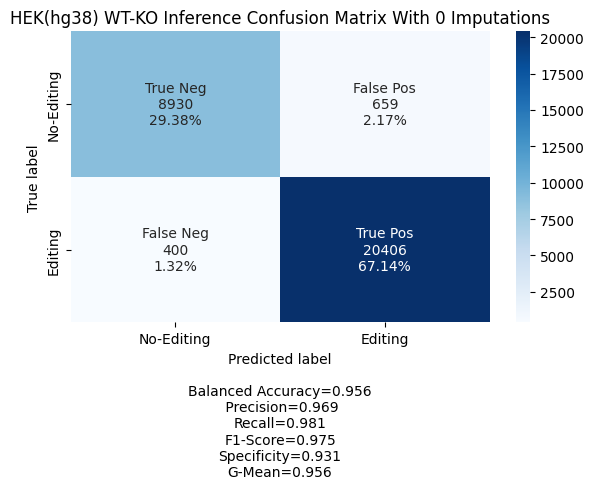

100%|██████████| 3/3 [01:37<00:00, 32.35s/it]


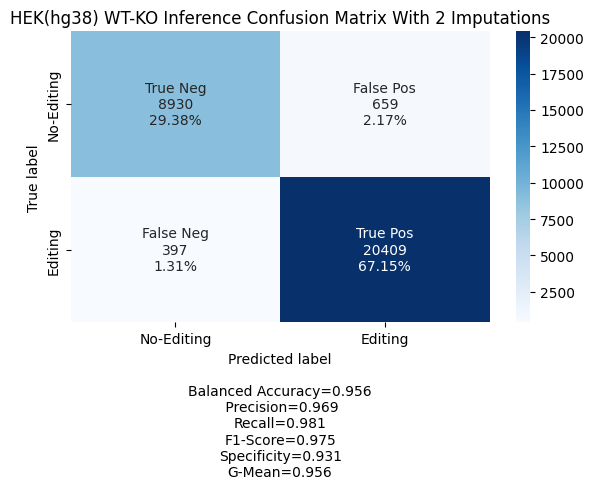

100%|██████████| 3/3 [01:36<00:00, 32.21s/it]


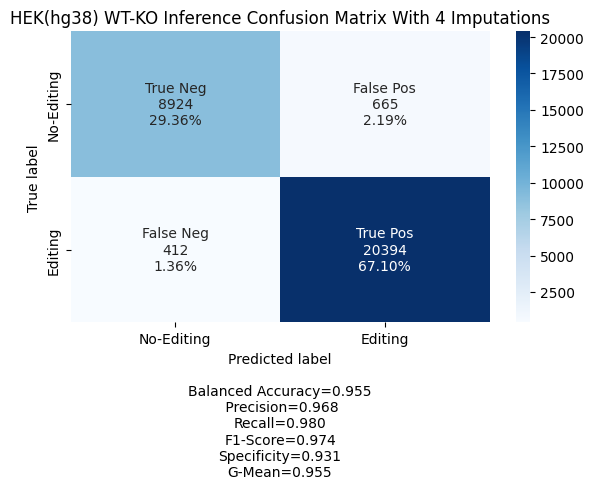

100%|██████████| 3/3 [01:39<00:00, 33.02s/it]


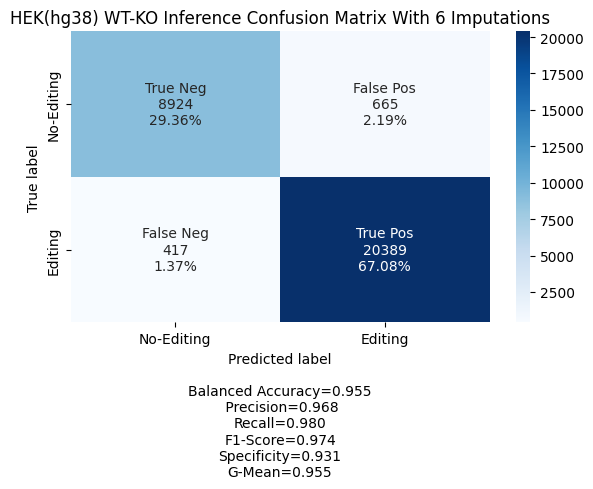

100%|██████████| 3/3 [01:39<00:00, 33.13s/it]


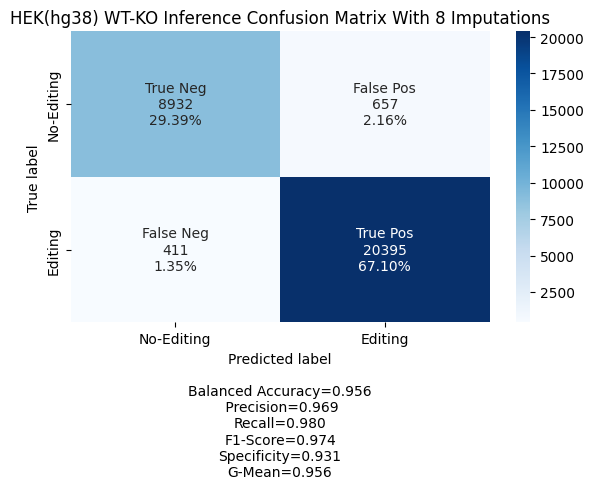

100%|██████████| 3/3 [01:37<00:00, 32.62s/it]


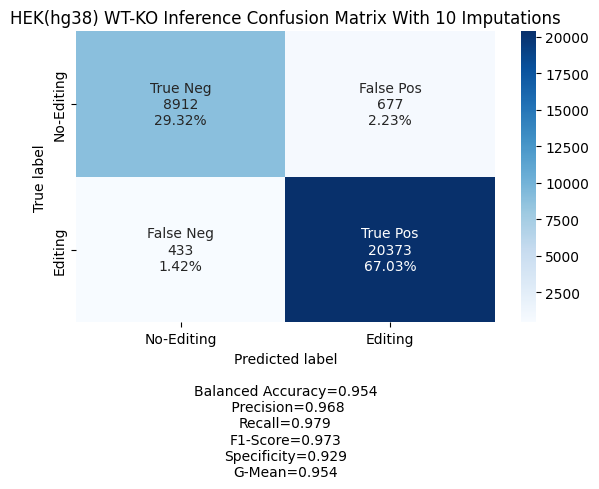

100%|██████████| 3/3 [01:40<00:00, 33.43s/it]


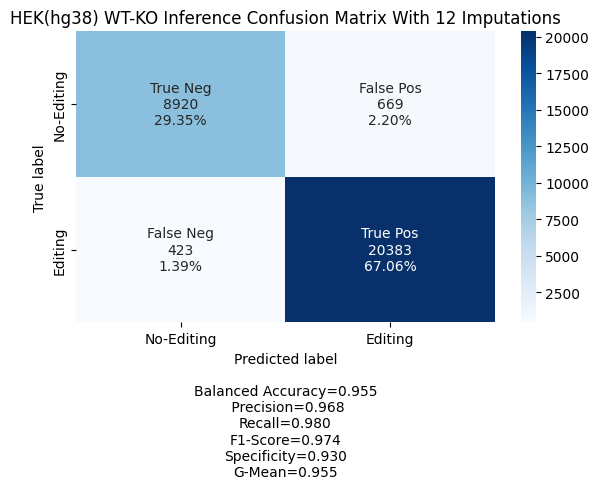

100%|██████████| 3/3 [01:34<00:00, 31.57s/it]


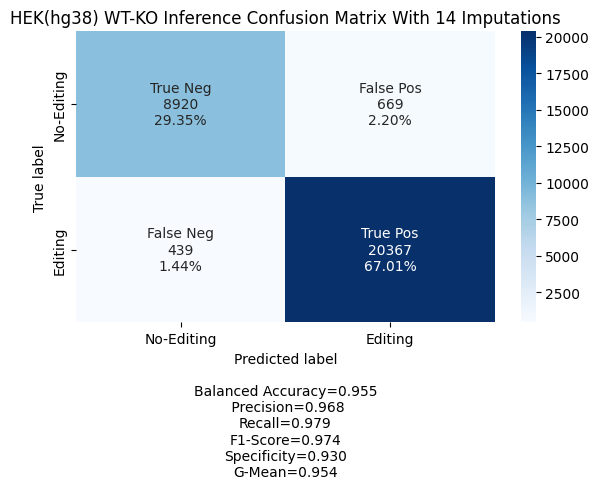

100%|██████████| 3/3 [01:37<00:00, 32.57s/it]


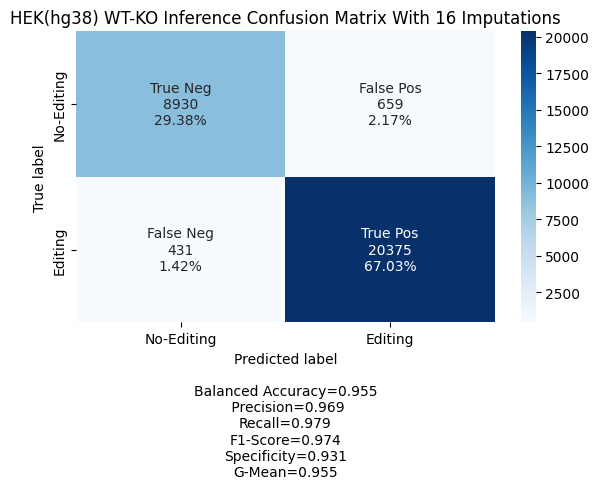

100%|██████████| 3/3 [01:37<00:00, 32.58s/it]


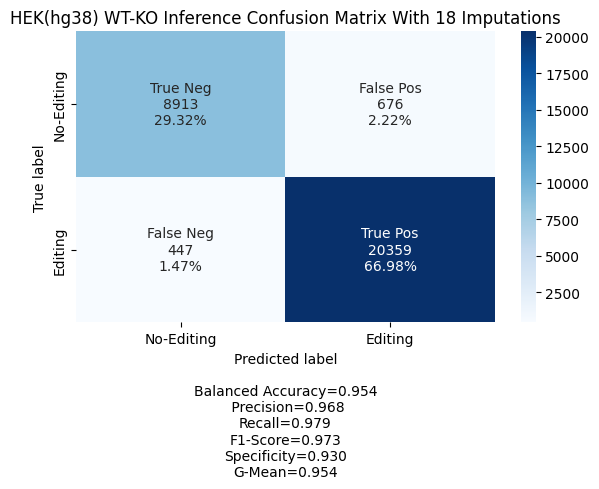

100%|██████████| 3/3 [01:35<00:00, 31.94s/it]


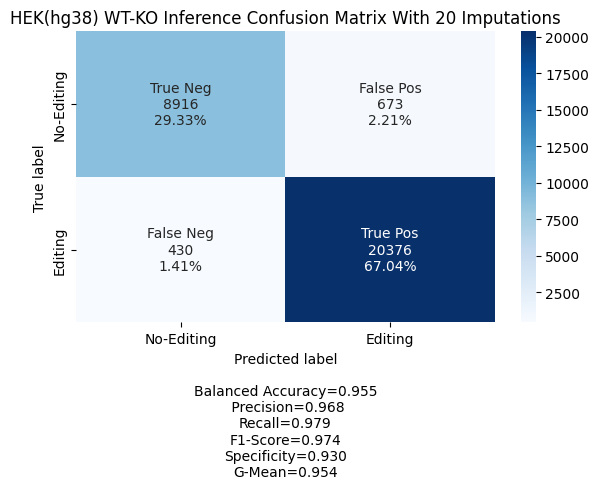

100%|██████████| 3/3 [01:38<00:00, 32.92s/it]


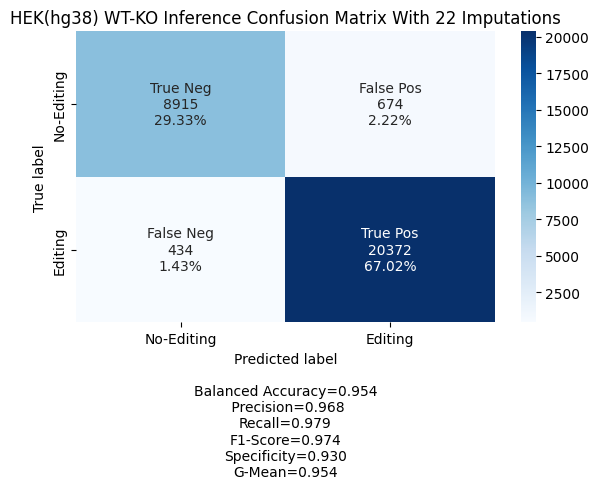

100%|██████████| 3/3 [01:39<00:00, 33.07s/it]


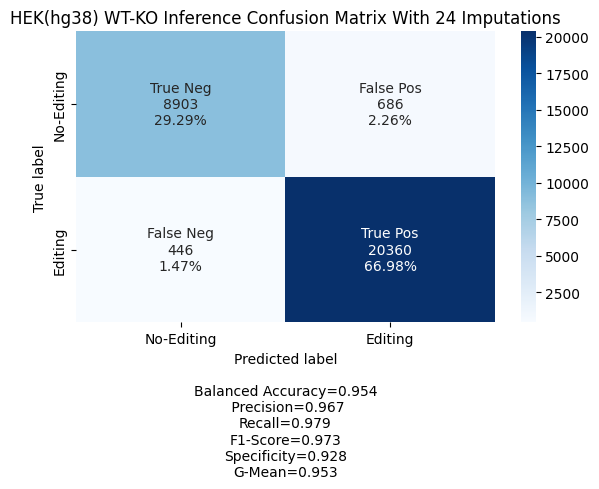

100%|██████████| 3/3 [01:39<00:00, 33.06s/it]


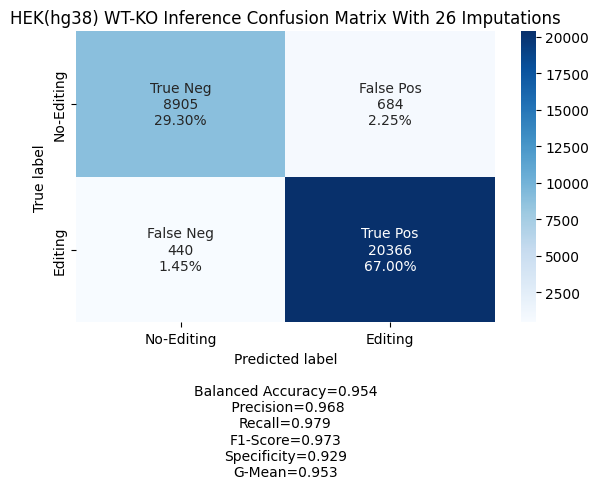

100%|██████████| 3/3 [01:36<00:00, 32.18s/it]


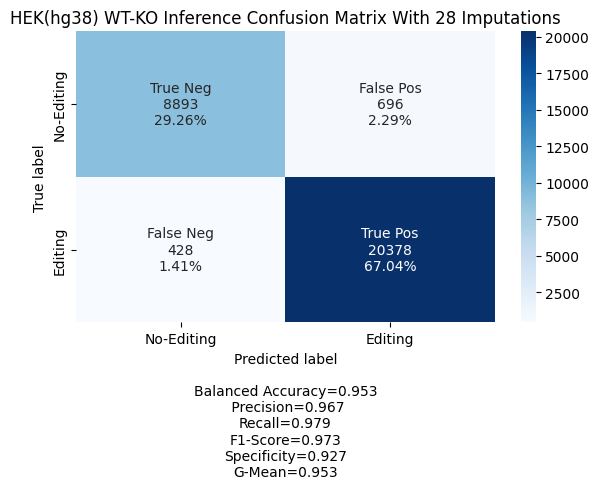

100%|██████████| 3/3 [01:37<00:00, 32.62s/it]


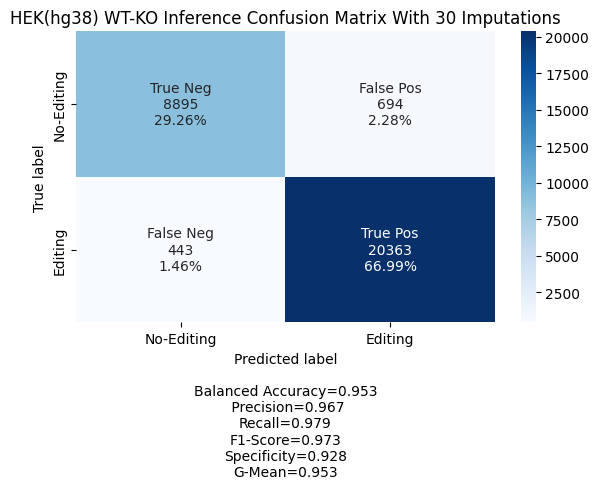

100%|██████████| 3/3 [01:38<00:00, 32.82s/it]


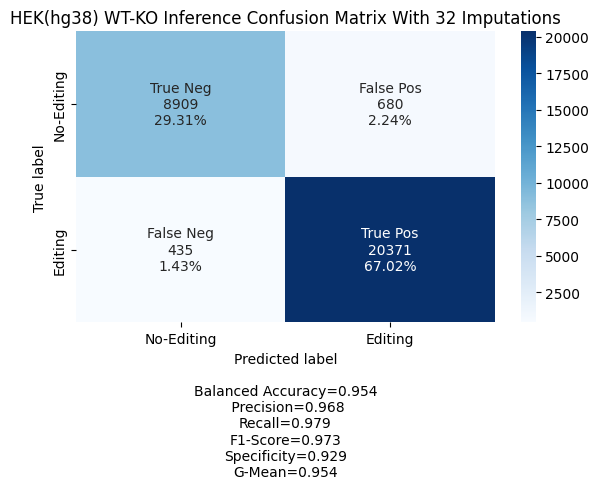

100%|██████████| 3/3 [01:40<00:00, 33.34s/it]


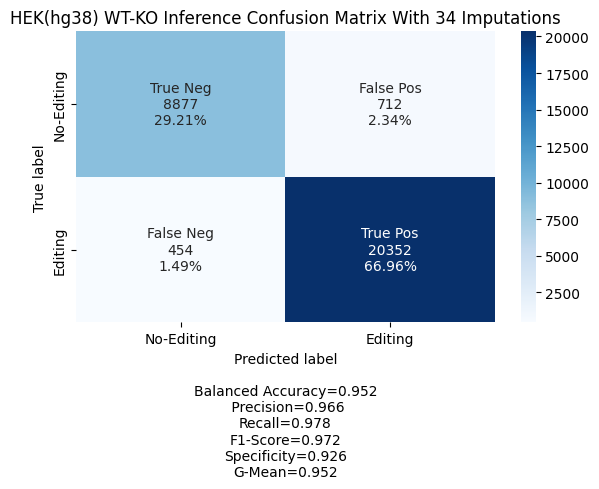

100%|██████████| 3/3 [01:41<00:00, 33.77s/it]


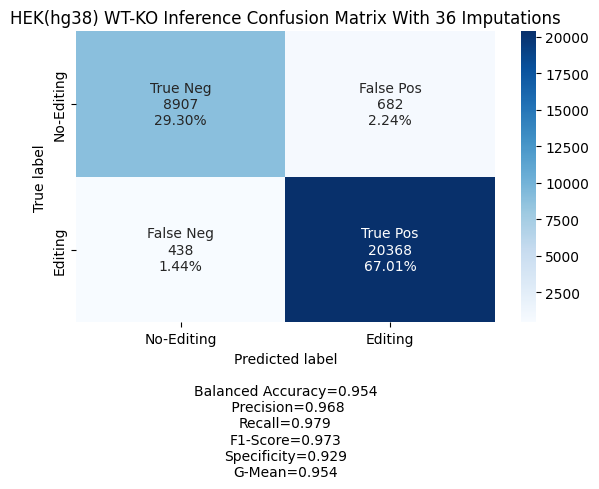

100%|██████████| 3/3 [01:40<00:00, 33.34s/it]


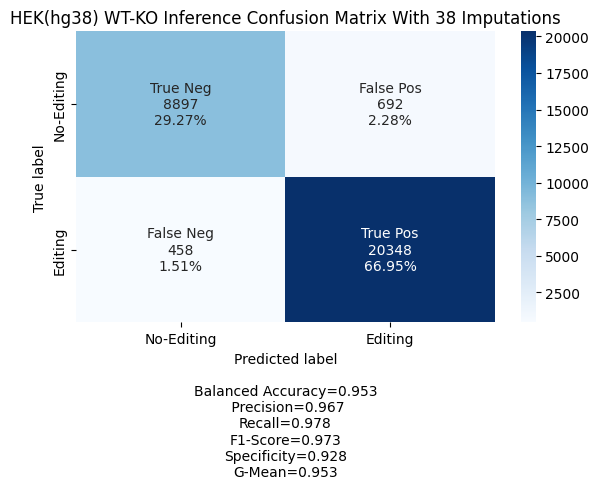

100%|██████████| 3/3 [01:40<00:00, 33.42s/it]


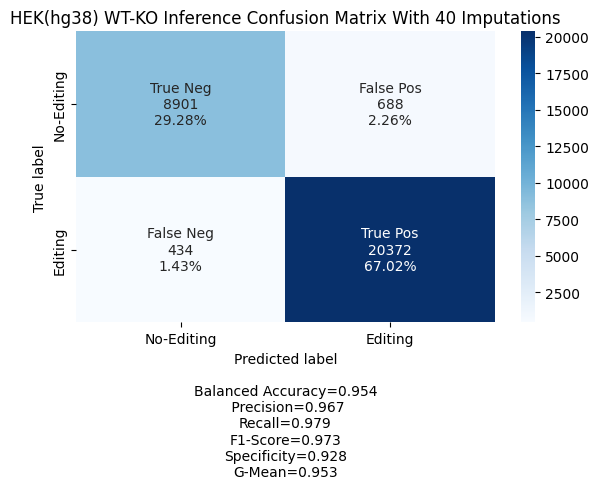

100%|██████████| 3/3 [01:39<00:00, 33.19s/it]


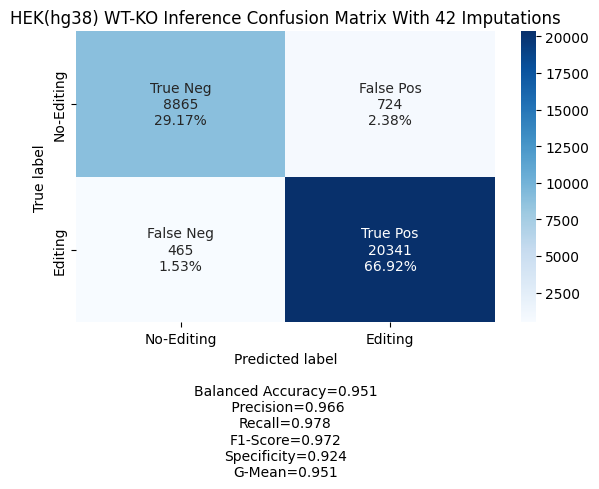

100%|██████████| 3/3 [01:41<00:00, 33.74s/it]


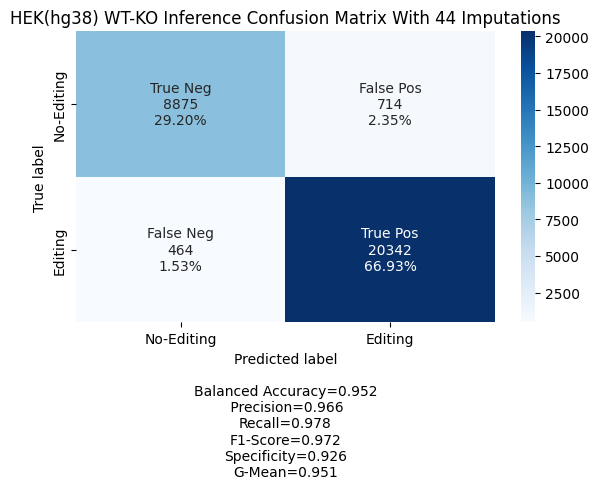

100%|██████████| 3/3 [01:41<00:00, 33.76s/it]


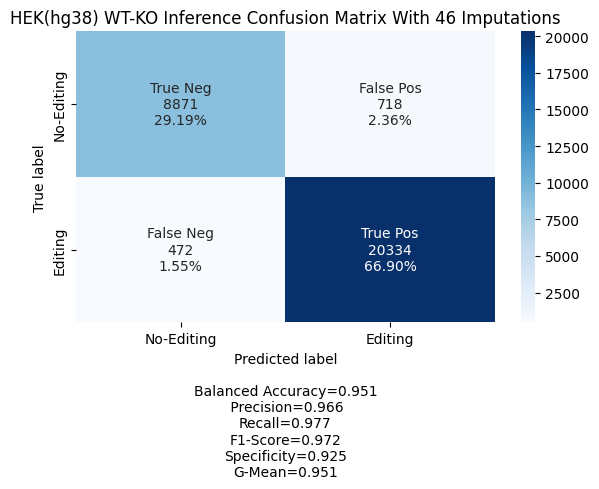

100%|██████████| 3/3 [01:40<00:00, 33.61s/it]


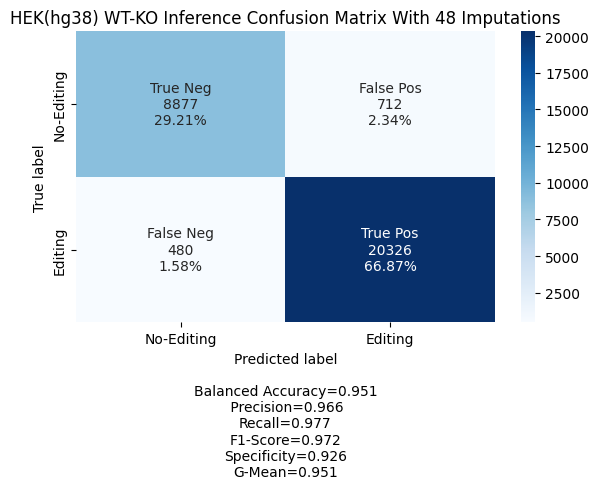

100%|██████████| 3/3 [01:40<00:00, 33.35s/it]


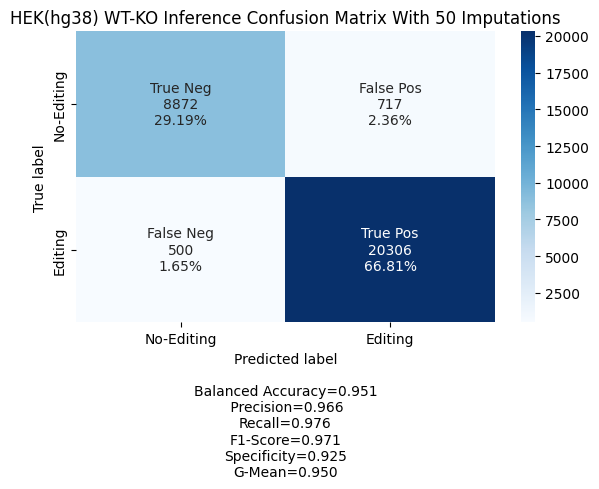

100%|██████████| 3/3 [01:42<00:00, 34.07s/it]


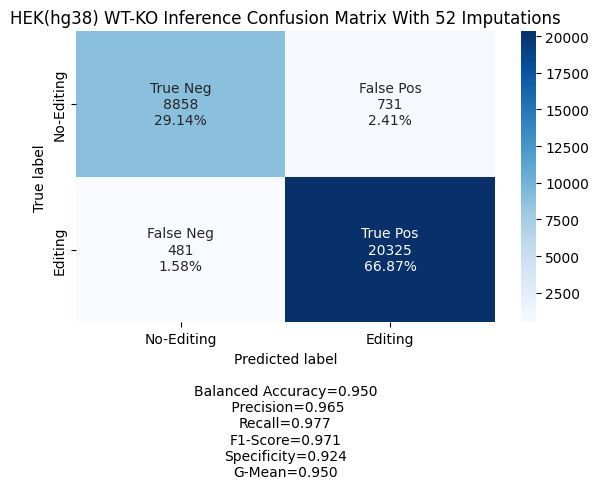

100%|██████████| 3/3 [01:42<00:00, 34.24s/it]


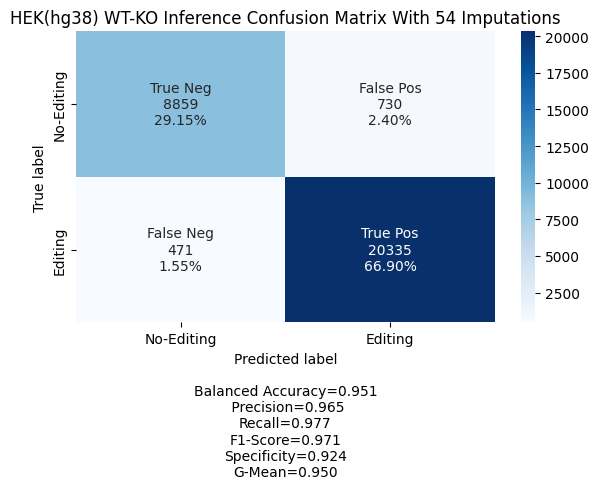

100%|██████████| 3/3 [01:42<00:00, 34.33s/it]


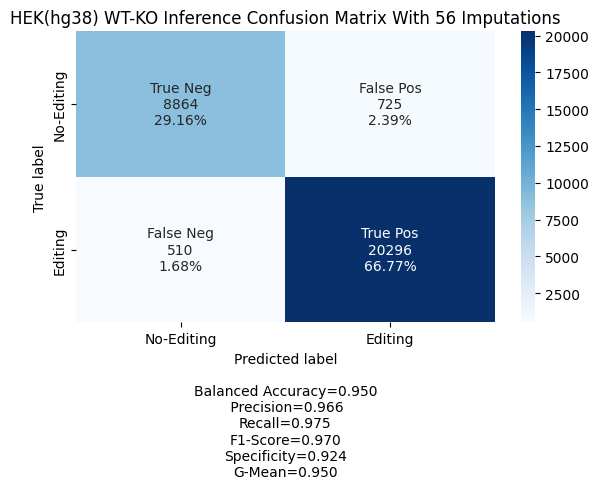

100%|██████████| 3/3 [01:41<00:00, 33.86s/it]


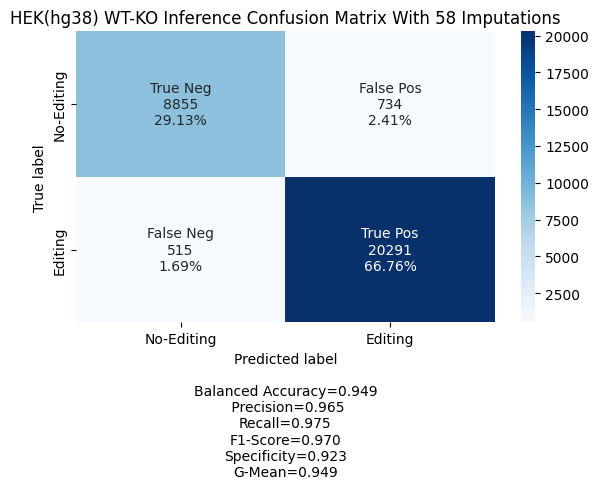

100%|██████████| 3/3 [01:41<00:00, 33.97s/it]


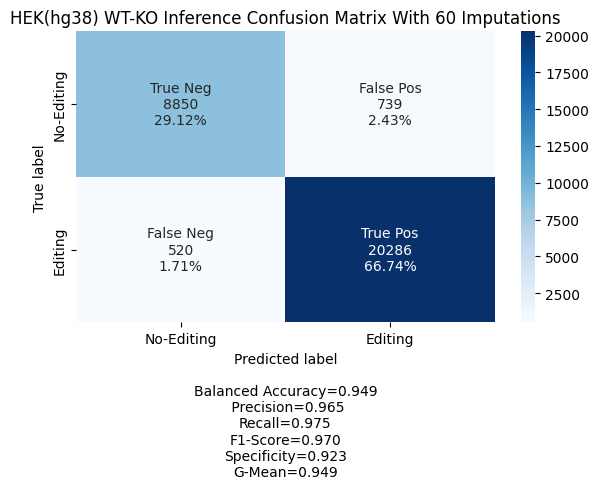

100%|██████████| 3/3 [01:41<00:00, 33.67s/it]


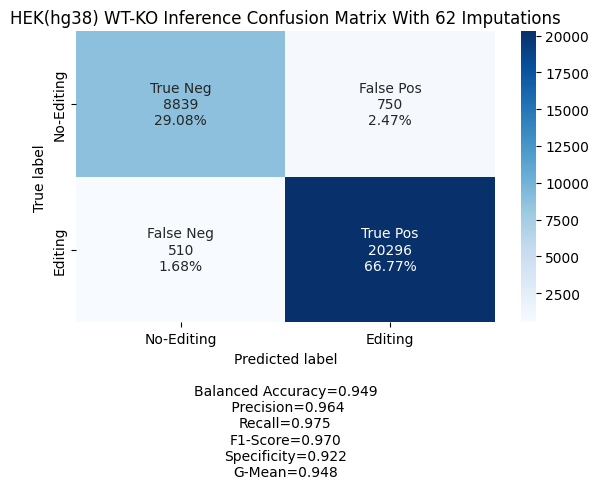

100%|██████████| 3/3 [01:41<00:00, 33.90s/it]


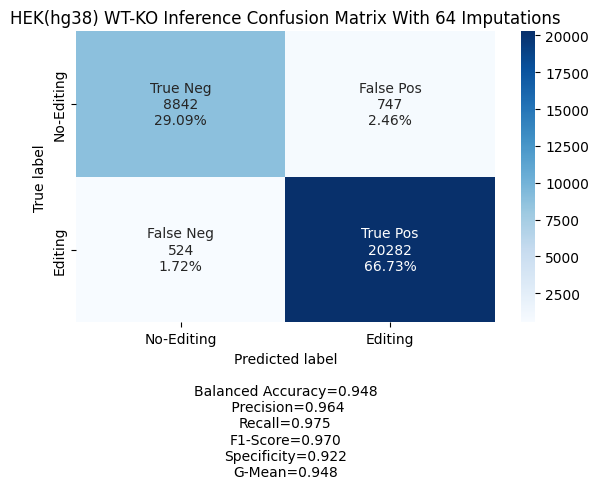

100%|██████████| 3/3 [01:42<00:00, 34.06s/it]


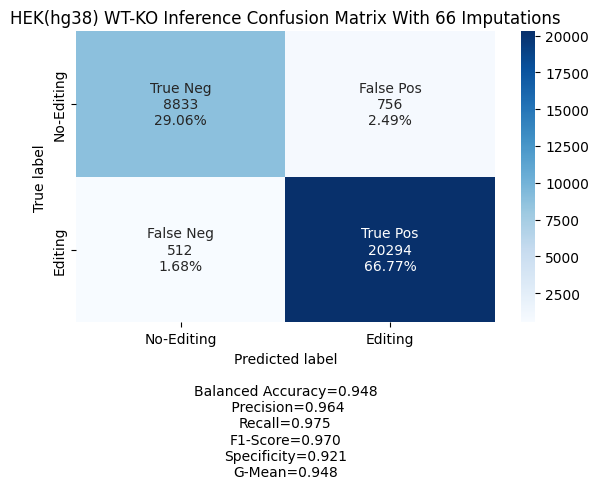

100%|██████████| 3/3 [01:42<00:00, 34.19s/it]


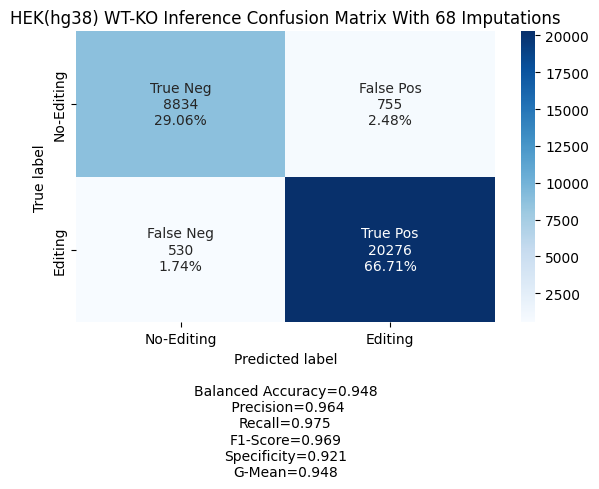

100%|██████████| 3/3 [01:44<00:00, 34.67s/it]


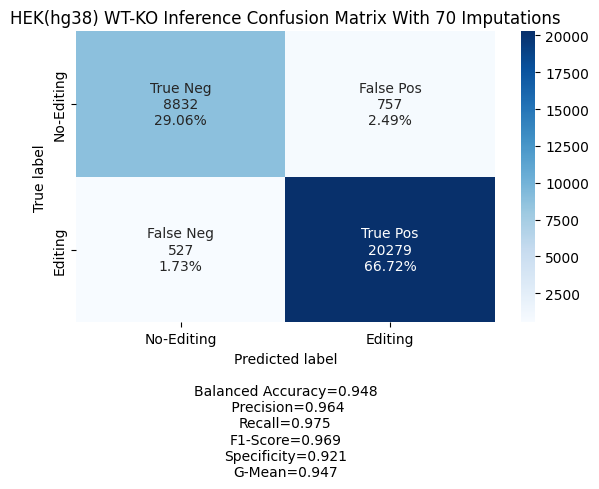

100%|██████████| 3/3 [01:41<00:00, 33.68s/it]


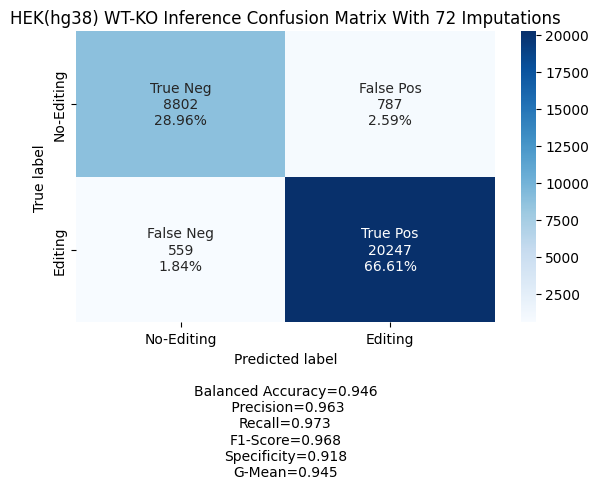

100%|██████████| 3/3 [01:43<00:00, 34.58s/it]


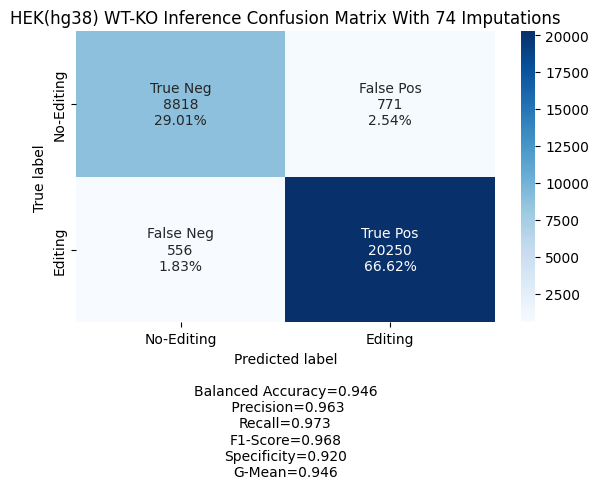

100%|██████████| 3/3 [01:41<00:00, 33.90s/it]


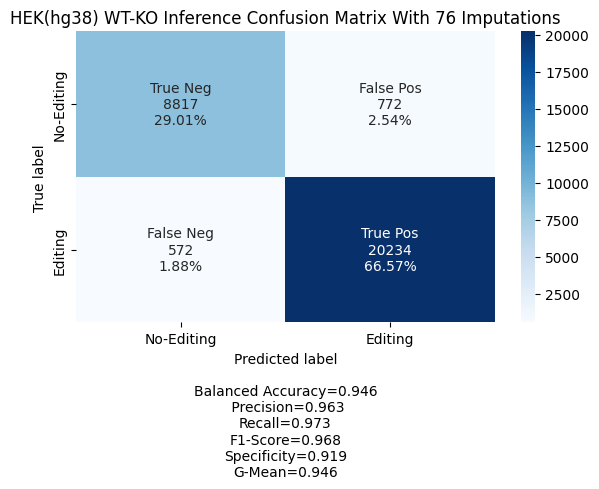

100%|██████████| 3/3 [01:42<00:00, 34.30s/it]


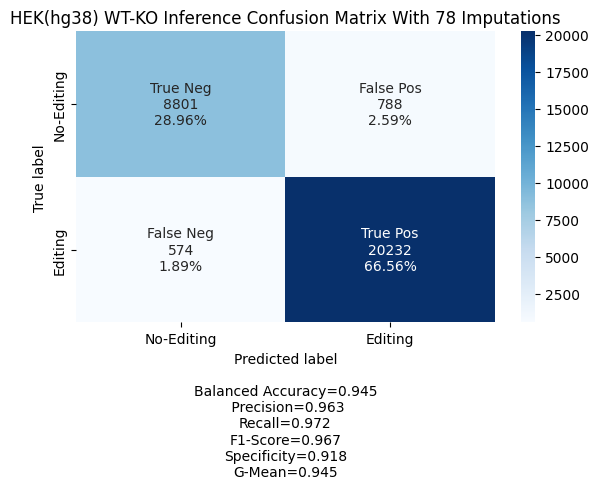

100%|██████████| 3/3 [01:42<00:00, 34.13s/it]


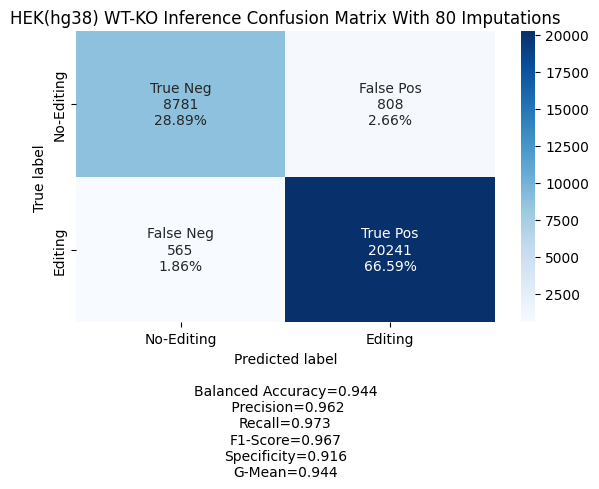

100%|██████████| 3/3 [01:42<00:00, 34.13s/it]


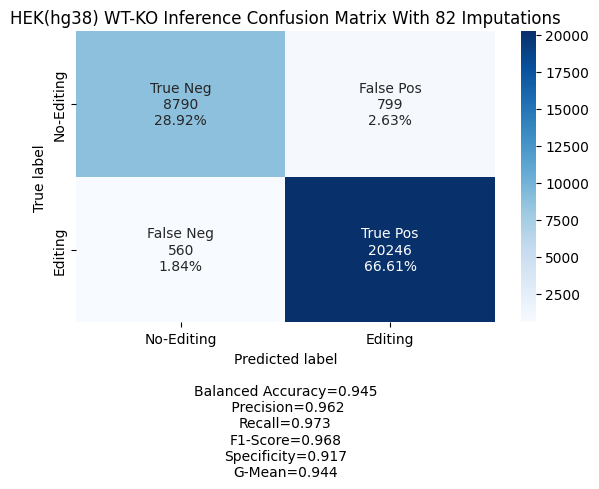

100%|██████████| 3/3 [02:01<00:00, 40.53s/it]


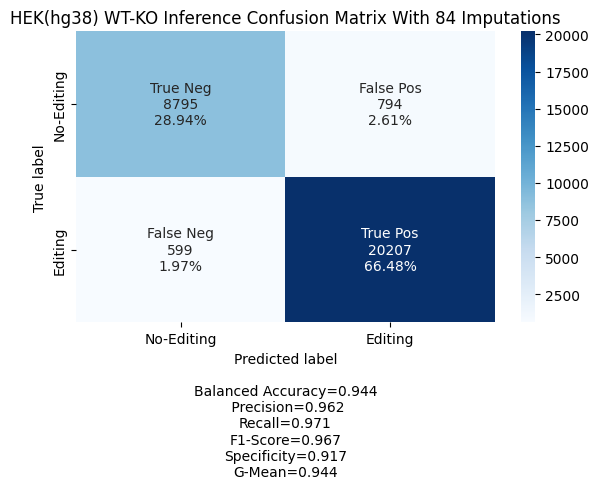

100%|██████████| 3/3 [01:43<00:00, 34.49s/it]


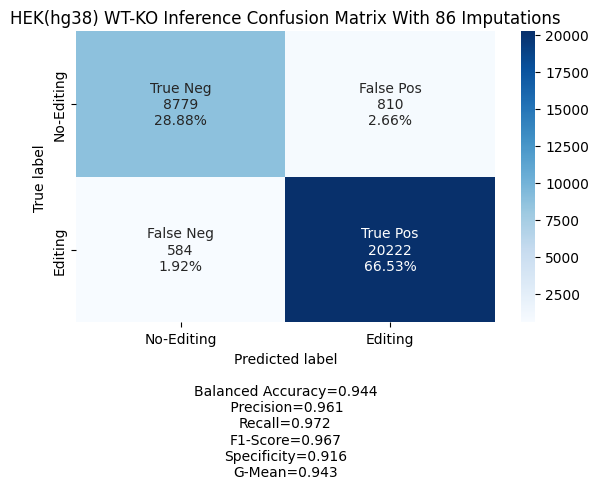

100%|██████████| 3/3 [01:42<00:00, 34.06s/it]


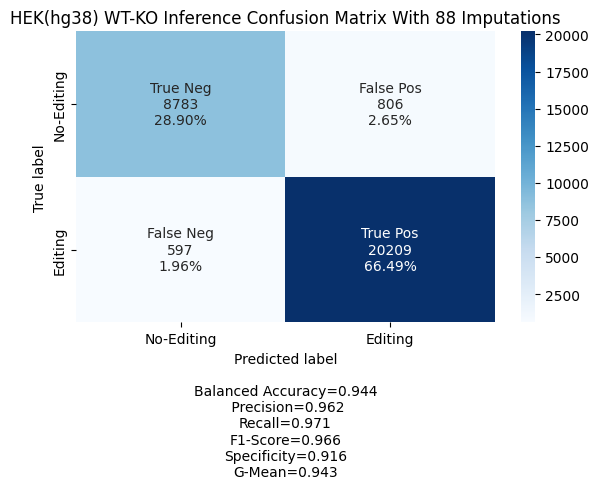

100%|██████████| 3/3 [01:44<00:00, 34.91s/it]


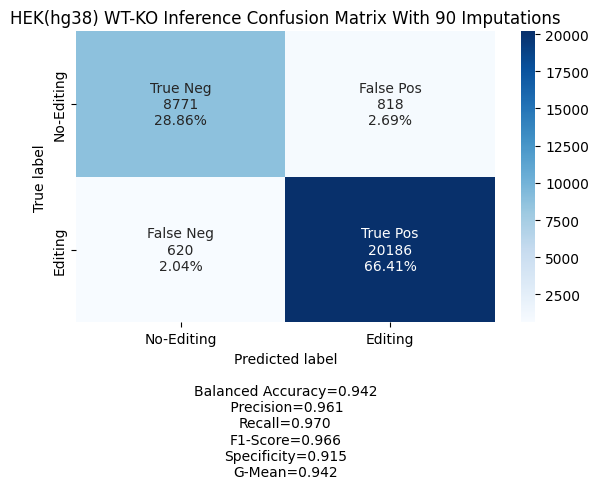

100%|██████████| 3/3 [01:44<00:00, 34.67s/it]


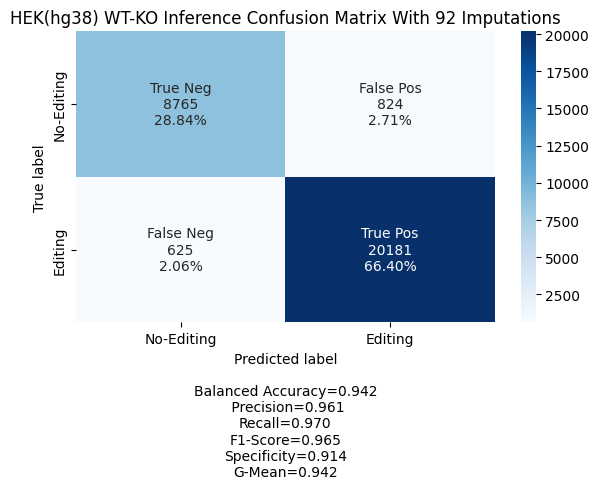

100%|██████████| 3/3 [01:41<00:00, 33.91s/it]


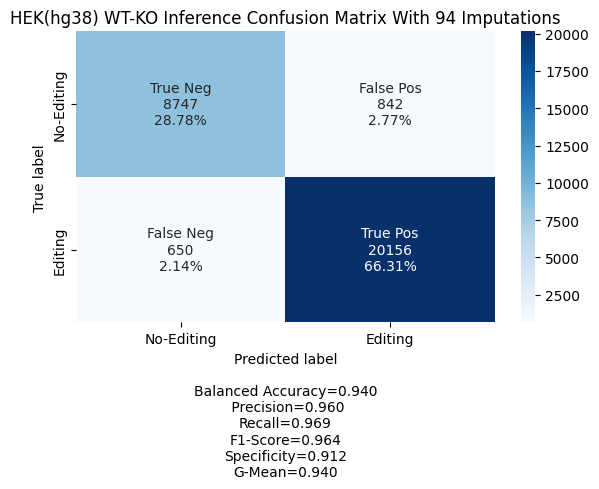

100%|██████████| 3/3 [01:42<00:00, 34.07s/it]


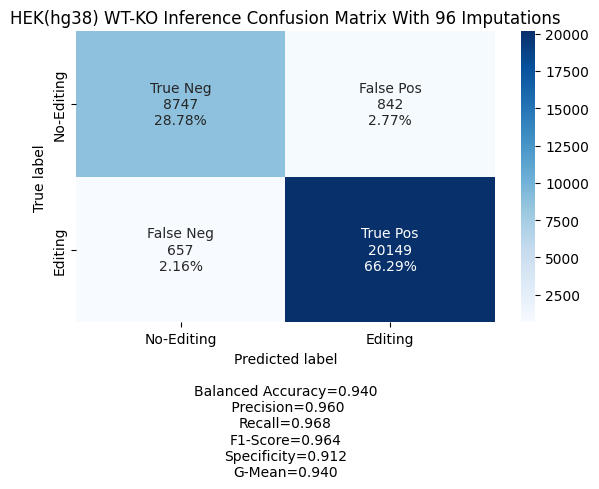

100%|██████████| 3/3 [01:43<00:00, 34.41s/it]


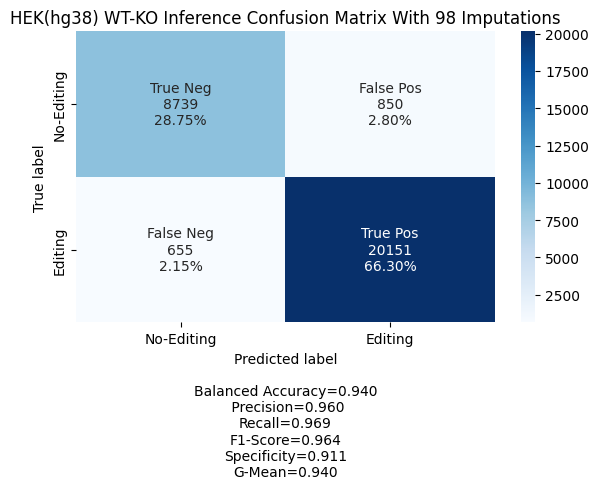

100%|██████████| 3/3 [01:43<00:00, 34.43s/it]


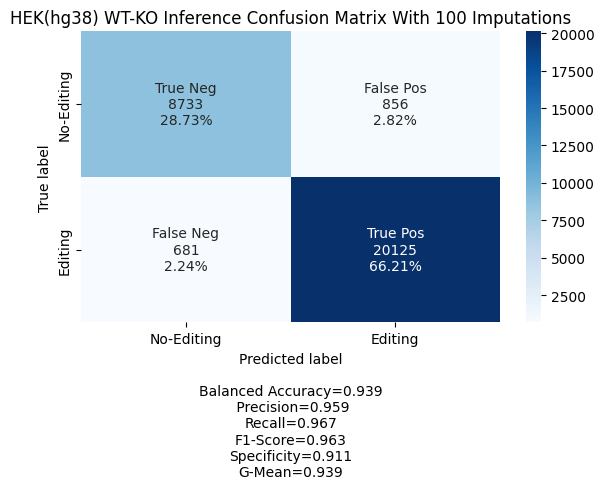

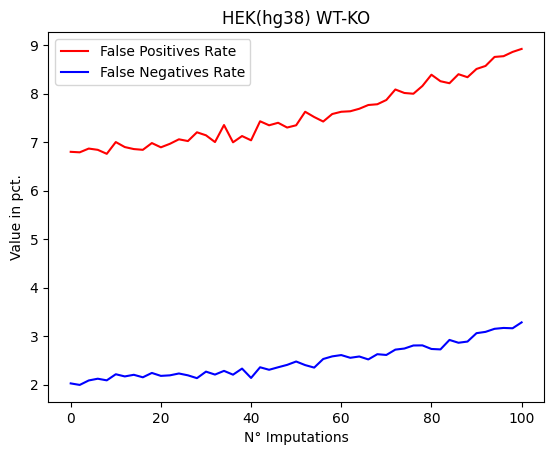

In [2]:
model_filepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/REDInet_models/REDInet_log_preprocessing_pos_zeros_snps_29_02_2024_22_25_45.h5"

cells = "HEK293T"

df, path = make_imputations(cells, model_filepath)

x = df.loc[:, "N_Imputations"].tolist()               
df.loc[:, "False Positives Rate"] = 100*(df.loc[:,"FP"]/(df.loc[:,"FP"]+df.loc[:, "TN"]))
df.loc[:, "False Negatives Rate"] = 100*(df.loc[:,"FN"]/(df.loc[:,"FN"]+df.loc[:, "TP"]))

fpr = df.loc[:, "False Positives Rate"].tolist()
fnr = df.loc[:, "False Negatives Rate"].tolist()
                 
                 
plt.plot(x, fpr, label = "False Positives Rate", color="red") 
plt.plot(x, fnr, label = "False Negatives Rate", color="blue") 
plt.xlabel('N° Imputations') 
plt.ylabel('Value in pct.') 
plt.title('HEK(hg38) WT-KO') 
plt.legend() 
plt.savefig(f"{path}/{cells}_Imputations_False_Positives_Rate_False_Negatives_Rate_plot_2.tiff", dpi=300, 
            bbox_inches='tight', facecolor='white', transparent=False) 
plt.show()